## Librerias 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from lib.LCWavelet import *
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import optuna

## Arquitectura del modelo

In [ ]:
class ShallueModel(nn.Module):
    def __init__(self, global_size=2001, local_size=201, num_classes=2, wavelet_levels=[]):
        super(ShallueModel, self).__init__()
        self.global_size = global_size
        self.local_size = local_size
        self.num_classes = num_classes
        if num_classes == 1:
            print("Binary classification, sigmoid activation will be used.")
        elif num_classes > 1:
            print("Multi-class classification, softmax activation will be used.")
            
        c_in = 2
        if len(wavelet_levels) > 0:
            c_in = len(wavelet_levels) * 2
            
        self.conv_global = nn.Sequential(
            nn.Conv1d(c_in, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(32, 64, 5),
            nn.ReLU(),
            nn.Conv1d(64, 64, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(64, 128, 5),
            nn.ReLU(),
            nn.Conv1d(128, 128, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(128, 256, 5),
            nn.ReLU(),
            nn.Conv1d(256, 256, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
        )
    
        
        self.conv_local = nn.Sequential(
            nn.Conv1d(c_in, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=2),
        )

        
        # Calcular automáticamente el número de features resultantes de la concatenación
        with torch.no_grad():
            dummy_global = torch.zeros(1, 2, self.global_size)
            dummy_local = torch.zeros(1, 2, self.local_size)
            out_global  = self.conv_global(dummy_global)
            out_local   = self.conv_local(dummy_local)

            
            # Flatten cada salida y sumar sus dimensiones
            num_features = out_global.view(1, -1).size(1) + out_local.view(1, -1).size(1)
            
        print("Número de features concatenados:", num_features)
        
        self.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, inputs):
        global_feat = self.conv_global(inputs[0])
        local_feat = self.conv_local(inputs[1])

        
        global_feat = global_feat.view(global_feat.size(0), -1)
        local_feat = local_feat.view(local_feat.size(0), -1)

        # Concatenación de todas las ramas
        x = torch.cat((global_feat, local_feat), dim=1)
        x = self.fc(x)
        if self.num_classes > 1:
            return F.softmax(x, dim=1)
        else:
            return torch.sigmoid(x)
    
class ShallueModel2D(nn.Module):
    def __init__(self, global_size=2001, local_size=201, num_classes=2):
        super().__init__()
        self.global_size = global_size
        self.local_size = local_size
        self.num_classes = num_classes

        if num_classes == 1:
            print("Binary classification → sigmoid output")
        else:
            print("Multi-class classification → softmax output")

        # --------------------------------------------------
        # Branch para la señal global, reformulada como "imagen" 2×L
        # --------------------------------------------------
        self.conv_global = nn.Sequential(
            # combina las dos “filas” (par/impar) en la primera convolución
            nn.Conv2d(1, 16, kernel_size=(2, 5)),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(1, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 5), stride=(1, 2)),

            nn.Conv2d(16, 32, kernel_size=(1, 5)),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(1, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 5), stride=(1, 2)),

            nn.Conv2d(32, 64, kernel_size=(1, 5)),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(1, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 5), stride=(1, 2)),

            nn.Conv2d(64, 128, kernel_size=(1, 5)),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(1, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 5), stride=(1, 2)),

            nn.Conv2d(128, 256, kernel_size=(1, 5)),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(1, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 5), stride=(1, 2)),
        )

        # --------------------------------------------------
        # Branch para la señal local, reformulada como "imagen" 2×L
        # --------------------------------------------------
        self.conv_local = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(2, 5)),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(1, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 7), stride=(1, 2)),

            nn.Conv2d(16, 32, kernel_size=(1, 5)),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(1, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 7), stride=(1, 2)),
        )

        # --------------------------------------------------
        # Calcular automáticamente cuántas características salen tras conv_global + conv_local
        # --------------------------------------------------
        with torch.no_grad():
            # Dummy de forma [batch=1, canales=1, altura=2, ancho=global_size]
            dg = torch.zeros(1, 1, 2, self.global_size)
            dl = torch.zeros(1, 1, 2, self.local_size)

            og = self.conv_global(dg)
            ol = self.conv_local(dl)

            num_features = og.view(1, -1).size(1) + ol.view(1, -1).size(1)

        print(f"Número de features concatenados: {num_features}")

        # --------------------------------------------------
        # Fully connected
        # --------------------------------------------------
        self.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_classes)
        )

    def forward(self, inputs):
        # inputs: tuple (global, local), cada uno [B, 2, L]
        g, l = inputs

        # convertimos a [B, 1, 2, L] para Conv2d
        g = g.unsqueeze(1)
        l = l.unsqueeze(1)

        # ramas convolucionales
        g_feat = self.conv_global(g)
        l_feat = self.conv_local(l)

        # aplanar y concatenar
        g_feat = g_feat.view(g_feat.size(0), -1)
        l_feat = l_feat.view(l_feat.size(0), -1)
        x = torch.cat((g_feat, l_feat), dim=1)

        # fully connected
        x = self.fc(x)

        # activación final
        if self.num_classes > 1:
            return F.softmax(x, dim=1)
        else:
            # para binary: devuelve [B, 1] con probabilidad
            return torch.sigmoid(x)

## Cargado de datos

In [3]:
def load_data(path, file_name):
    lc = LightCurveWaveletGlobalLocalCollection.from_pickle(path + file_name)
    try:
        getattr(lc, 'levels')
    except AttributeError:
        lc.levels = [1, 2, 3, 4]
    return lc
        
path='all_data/'
files = os.listdir(path)
kepler_files = [f for f in files if f.endswith('.pickle')]
light_curves = []

for file in tqdm(kepler_files, desc='Loading data'):
    light_curves.append(load_data(path, file))

Loading data: 100%|██████████| 9346/9346 [04:54<00:00, 31.78it/s]


### Separar entre los confirmados y candidatos

In [4]:
candidates = [lc for lc in light_curves if lc.headers['class'] == 'CANDIDATE']
print("Número de candidatos:", len(candidates))

confirmed = [lc for lc in light_curves if lc.headers['class'] == 'CONFIRMED' or lc.headers['class'] == 'FALSE POSITIVE']
print("Número de confirmados:", len(confirmed))

classes = {'FALSE POSITIVE': 0, 'CONFIRMED': 1}
print("Clases:", classes)

Número de candidatos: 2046
Número de confirmados: 7300
Clases: {'FALSE POSITIVE': 0, 'CONFIRMED': 1}


In [6]:
global_odd = []
global_even = []
local_odd = []
local_even = []
wl_levels = []
labels = []

for lc in tqdm(confirmed, desc='Processing light curves'):
    global_odd.append(lc.pliegue_impar_global._light_curve.flux.value)
    global_even.append(lc.pliegue_par_global._light_curve.flux.value)
    local_odd.append(lc.pliegue_impar_local._light_curve.flux.value)
    local_even.append(lc.pliegue_par_local._light_curve.flux.value)
    # Extraer los niveles de wavelet
    wl_levels.append({
        'global_odd': lc.pliegue_impar_global._lc_w_collection,
        'global_even': lc.pliegue_par_global._lc_w_collection,
        'local_odd': lc.pliegue_impar_local._lc_w_collection,
        'local_even': lc.pliegue_par_local._lc_w_collection
    })
    # Convertir la clase a un número entero
    labels.append(classes[lc.headers['class']])
    
print("Número de datos:", len(global_odd))
print('Elementos de cada clase:', {k: labels.count(k) for k in set(labels)})


Processing light curves: 100%|██████████| 7300/7300 [00:00<00:00, 108634.89it/s]

Número de datos: 7300
Elementos de cada clase: {0: 4637, 1: 2663}


Text(0, 0.5, 'Flux')

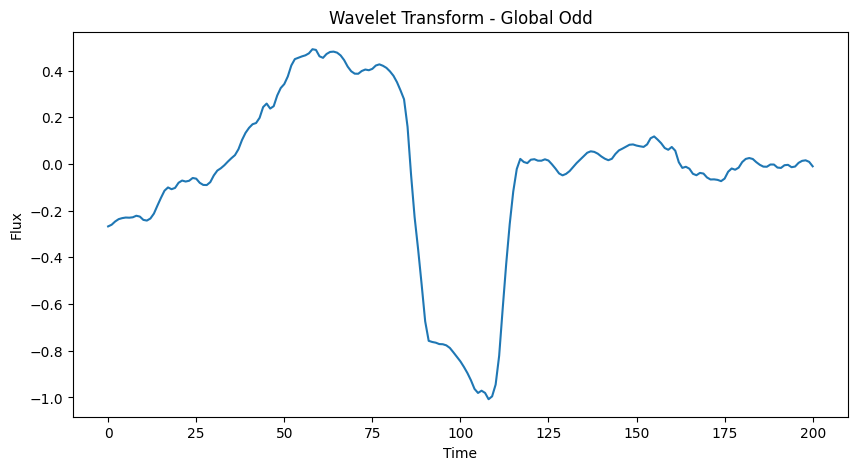

In [19]:
array = wl_levels[5]['local_even'][0][0]
plt.figure(figsize=(10, 5))
plt.plot(array, label='Global Odd')
plt.title('Wavelet Transform - Global Odd')
plt.xlabel('Time')
plt.ylabel('Flux')

#### Ajustar los datos para que sean equiprobables (data augmentation)

In [6]:
# Ajustar el numero de elementos de cada clase
min_class_size = min([list(labels).count(i) for i in set(labels)])
max_class_size = max([list(labels).count(i) for i in set(labels)])
min_class = min([i for i in set(labels) if list(labels).count(i) == min_class_size])
max_class = max([i for i in set(labels) if list(labels).count(i) == max_class_size])
print("Tamaño máximo de clase:", max_class_size)
print("Tamaño mínimo de clase:", min_class_size)

# coger los datos de la clase con menos elementos y generar un dato nuevo dandole la vuelta a la señal hasta que tenga el mismo número de elementos que la clase con más elementos
for i in range(len(labels)):
    if labels[i] == min_class: # clase con menos elementos
        global_odd.append(global_odd[i][::-1])
        global_even.append(global_even[i][::-1])
        local_odd.append(local_odd[i][::-1])
        local_even.append(local_even[i][::-1])
        labels.append(labels[i])
    if labels[i] == max_class and labels.count(max_class) < min_class_size*2: # clase con más elementos
        global_odd.append(global_odd[i][::-1])
        global_even.append(global_even[i][::-1])
        local_odd.append(local_odd[i][::-1])
        local_even.append(local_even[i][::-1])
        labels.append(labels[i])
        
print("Número de datos tras ajuste:", len(global_odd))
print('Elementos de cada clase tras ajuste:', {k: list(labels).count(k) for k in set(labels)})


Tamaño máximo de clase: 4637
Tamaño mínimo de clase: 2663
Número de datos tras ajuste: 10652
Elementos de cada clase tras ajuste: {0: 5326, 1: 5326}


### Separar las muestras en train y test

In [54]:
items = []
wavelet_level = 4
for i in tqdm(range(len(global_odd)), desc='Creating items'):
    item = {
        'global_odd': wl_levels[i]['global_odd'][wavelet_level-1][0],
        'global_even': wl_levels[i]['global_even'][wavelet_level-1][0],
        'local_odd': wl_levels[i]['local_odd'][wavelet_level-1][0],
        'local_even': wl_levels[i]['local_even'][wavelet_level-1][0],
        # 'global_odd': global_odd[i],
        # 'global_even': global_even[i],
        # 'local_odd': local_odd[i],
        # 'local_even': local_even[i],
        'label': labels[i]
    }
    items.append(item)

# train, test = train_test_split(items, test_size=0.3, random_state=42)
train, test = train_test_split(items, test_size=0.3)
train_global = torch.tensor([[item['global_odd'], item['global_even']] for item in train])
train_local = torch.tensor([[item['local_odd'], item['local_even']] for item in train])
train_labels = torch.tensor([item['label'] for item in train])

test_global = torch.tensor([[item['global_odd'], item['global_even']] for item in test])
test_local = torch.tensor([[item['local_odd'], item['local_even']] for item in test])
test_labels = torch.tensor([item['label'] for item in test])

train_dataset = torch.utils.data.TensorDataset(train_global, train_local, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_global, test_local, test_labels)

print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))

Creating items: 100%|██████████| 7300/7300 [00:00<00:00, 348824.50it/s]

Tamaño del conjunto de entrenamiento: 5110
Tamaño del conjunto de prueba: 2190


## Entrenar el modelo

#### Definir device en caso de usar GPU o CPU

In [21]:
try:
    import torch_directml
    if torch_directml.is_available():
        device = torch_directml.device()
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Dispositivo:", device)
except ImportError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Dispositivo:", device)

Dispositivo: privateuseone:0


In [22]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

In [ ]:
def optuna_search(trial):
    # Definir los hiperparámetros a optimizar
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    # learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2])
    # num_epochs = trial.suggest_int('num_epochs', 50, 100, step=10)
    num_epochs = trial.suggest_categorical('num_epochs', [50, 65, 80, 100])
    # weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2)
    weight_decay = trial.suggest_categorical('weight_decay', [1e-6, 1e-5, 1e-4, 1e-3])
    criterion = trial.suggest_categorical('loss_fn', [0, 1]) # 0: CrossEntropy, 1: BCEWithLogits, 2: FocalLoss
    num_classes = 1
    if criterion == 0:
        criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 1.74]).to(device))
        num_classes = 2
    elif criterion == 1:
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.74]).to(device))
    elif criterion == 2:
        criterion = FocalLoss(gamma=2.0, alpha=0.25).to(device)

    # Crear el modelo
    model = ShallueModel(num_classes=num_classes).to(device)
    
    # Definir el optimizador y la función de pérdida
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([fraction]).to(device))

    # Crear los DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Entrenar el modelo
    model.train()
    for batch, data in enumerate(train_loader):
        global_s, local_s, labels = data
        # check if any tensor is empty
        if global_s.numel() == 0 or local_s.numel() == 0:
            continue
        # check if any tensor has nan
        if torch.isnan(global_s).any() or torch.isnan(local_s).any():
            continue
        # Move data to device
        global_s = global_s.to(device)#.unsqueeze(1).float()
        local_s = local_s.to(device)#.unsqueeze(1).float()
        labels = labels.to(device)
        
        optimizer.zero_grad()
        # Forward propagation
        outputs = model((global_s, local_s))
        
        if type(criterion) == nn.BCEWithLogitsLoss or type(criterion) == FocalLoss:
            # elimnar la dimensión extra de outputs
            outputs = outputs.squeeze(1)
            labels = labels.float()
        # Compute loss and backpropagation            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    # Evaluar el modelo
    model.eval()
    test_size = len(test_loader.dataset)
    n_batches = len(test_loader)
    total_loss = 0.0
    correct = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for batch, data in enumerate(test_loader):
            global_s, local_s, labels = data
            # check if any tensor is empty
            if global_s.numel() == 0 or local_s.numel() == 0:
                continue
            # check if any tensor has nan
            if torch.isnan(global_s).any() or torch.isnan(local_s).any():
                continue
            # Move data to device
            global_s = global_s.to(device).float()#.unsqueeze(1).float()
            local_s = local_s.to(device).float()#.unsqueeze(1).float()
            labels = labels.to(device)
            
            outputs = model((global_s, local_s))
            if type(criterion) == nn.BCEWithLogitsLoss or type(criterion) == FocalLoss:
            # elimnar la dimensión extra de outputs
                outputs = outputs.squeeze(1)
                labels = labels.float()

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            if type(criterion) == nn.BCEWithLogitsLoss or type(criterion) == FocalLoss:
                predicted = (outputs > 0.5).float()
            else:
                _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == labels).sum().item()
            labels = labels.cpu().numpy()
            predicted = predicted.cpu().numpy()
            
            all_labels.extend(labels)
            all_predictions.extend(predicted)
    
    accuracy = correct / test_size
    val_loss = total_loss / n_batches
    
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    
    return accuracy, f1, precision, recall, val_loss

# Ejecutar la búsqueda de hiperparámetros
study = optuna.create_study(directions=["maximize", "maximize", "maximize", "maximize", "minimize"], storage="sqlite:///optuna_study.db", study_name="shallue_model6", load_if_exists=True)
# Establecer el sampler para la búsqueda de hiperparámetros
study.optimize(optuna_search, n_trials=40, show_progress_bar=True, n_jobs=1)
# Imprimir los mejores hiperparámetros y resultados
print("Mejores hiperparámetros encontrados:")
best = None
for t in study.best_trials:
    if best is None or (t.values[0] > best.values[0] and t.values[1] > best.values[1] and t.values[2] > best.values[2] and t.values[3] > best.values[3] and t.values[4] < best.values[4]):
        best = t

print(f"Batch size: {best.params['batch_size']}")
print(f"Learning rate: {best.params['learning_rate']}")
print(f"Num epochs: {best.params['num_epochs']}")
print(f"Weight decay: {best.params['weight_decay']}")
print(f"Loss function: {best.params['loss_fn']}")
print(f"Accuracy: {best.values[0]}")
print(f"F1 Score: {best.values[1]}")
print(f"Precision: {best.values[2]}")
print(f"Recall: {best.values[3]}")
print(f"Validation loss: {best.values[4]}")

In [55]:
batch_size = 64
num_epochs = 100
learning_rate = 0.0001
l2_penalty = 1e-4 #0.003380
dropout = 0.006516
# fraction = max_class_size / min_class_size
fraction = 1.74 #1.74
print("Fracción:", fraction)
fraction = torch.tensor(fraction, device=device) #torch.tensor(0.9342, device=device) # peso positivo para la función de pérdida BCEWithLogitsLoss
n_classes = 1 # si pones 1 usa sigmoid, si pones >1 usa softmax
if n_classes > 1:
    loss_fn = nn.CrossEntropyLoss() # para clasificación multiclase
else:
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=fraction) # para clasificación binaria con sigmoid
    # loss_fn = FocalLoss(gamma=2.0, alpha=0.25) # para clasificación binaria con sigmoid y focal loss
    
model = ShallueModel2D(global_size=2001, local_size=201, num_classes=n_classes).to(device)
# if input("¿Quieres inicializar el modelo? (s/n): ").lower() == 's':  
#     try: 
#         model.load_state_dict(torch.load('models/Shallue_model.pth'))
#         model.eval()
#     except:
#         print("No se pudo cargar el modelo. Se inicializa uno nuevo.")


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_penalty)
schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Fracción: 1.74
Binary classification → sigmoid output
Número de features concatenados: 14336


In [24]:
def train_fn(model, train_loader, optimizer, loss_fn):
    model.train()
    train_size = len(train_loader.dataset)
    n_batches = len(train_loader)
    total_loss = 0.0
    correct = 0
    for batch, data in enumerate(train_loader):
        global_s, local_s, labels = data
        # check if any tensor is empty
        if global_s.numel() == 0 or local_s.numel() == 0:
            continue
        # check if any tensor has nan
        if torch.isnan(global_s).any() or torch.isnan(local_s).any():
            continue
        # Move data to device
        global_s = global_s.to(device)#.unsqueeze(1).float()
        local_s = local_s.to(device)#.unsqueeze(1).float()
        labels = labels.to(device)
        
        optimizer.zero_grad()
        # Forward propagation
        outputs = model((global_s, local_s))
        
        if type(loss_fn) == nn.BCEWithLogitsLoss or type(loss_fn) == FocalLoss:
            # elimnar la dimensión extra de outputs
            outputs = outputs.squeeze(1)
            labels = labels.float()
        # Compute loss and backpropagation            
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if type(loss_fn) == nn.BCEWithLogitsLoss or type(loss_fn) == FocalLoss:
            predicted = (outputs > 0.5).float()
        else:
            _, predicted = torch.max(outputs.data, 1)
            
        correct += (predicted == labels).sum().item()

    accuracy = correct / train_size
    train_loss = total_loss / n_batches
        
    return train_loss, accuracy


def val_fn(model, test_loader, loss_fn):
    model.eval()
    test_size = len(test_loader.dataset)
    n_batches = len(test_loader)
    total_loss = 0.0
    correct = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for batch, data in enumerate(test_loader):
            global_s, local_s, labels = data
            # check if any tensor is empty
            if global_s.numel() == 0 or local_s.numel() == 0:
                continue
            # check if any tensor has nan
            if torch.isnan(global_s).any() or torch.isnan(local_s).any():
                continue
            # Move data to device
            global_s = global_s.to(device)#.unsqueeze(1).float()
            local_s = local_s.to(device)#.unsqueeze(1).float()
            labels = labels.to(device)
            
            outputs = model((global_s, local_s))
            if type(loss_fn) == nn.BCEWithLogitsLoss or type(loss_fn) == FocalLoss:
            # elimnar la dimensión extra de outputs
                outputs = outputs.squeeze(1)
                labels = labels.float()

            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            
            if type(loss_fn) == nn.BCEWithLogitsLoss or type(loss_fn) == FocalLoss:
                predicted = (outputs > 0.5).float()
            else:
                _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == labels).sum().item()
            labels = labels.cpu().numpy()
            predicted = predicted.cpu().numpy()
            
            all_labels.extend(labels)
            all_predictions.extend(predicted)
    
    accuracy = correct / test_size
    val_loss = total_loss / n_batches
    
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    
    return val_loss, accuracy, f1, precision, recall

In [56]:
%matplotlib inline
prev_val_loss = float('inf')
patience = 10
early_stopping_counter = 0
verbose = False
for epoch in tqdm(range(num_epochs)):
    # print(f'Epoch {epoch + 1}/{num_epochs}', '------'*20)
    train_loss, train_accuracy = train_fn(model, train_loader, optimizer, loss_fn)
    # print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    
    val_loss, val_accuracy, f1, precision, recall = val_fn(model, test_loader, loss_fn)
    # print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    # print(f'F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    schedule.step(val_loss)
    
    if verbose:
        print(f'Epoch {epoch}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        print(f'F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    elif (epoch+1) % 10 == 0:
        # simple print every 10 epochs
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        print(f'F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    
    # early stopping
    if val_loss > prev_val_loss:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping")
            break
    else:
        early_stopping_counter = 0
        # Save the model if validation loss decreases
        # torch.save(model.state_dict(), 'models/Shallue_model.pth')
        # print("Modelo guardado")
    
    prev_val_loss = val_loss

print("Entrenamiento y validación completados.", '------'*20)

 10%|█         | 10/100 [00:20<03:03,  2.04s/it]

Epoch 10/100
Train Loss: 0.8124, Train Accuracy: 0.6284
Validation Loss: 0.8080, Validation Accuracy: 0.6242
F1 Score: 0.5779, Precision: 0.7008, Recall: 0.6629


 20%|██        | 20/100 [00:41<02:44,  2.05s/it]

Epoch 20/100
Train Loss: 0.7807, Train Accuracy: 0.6793
Validation Loss: 0.7841, Validation Accuracy: 0.6584
F1 Score: 0.6891, Precision: 0.6905, Recall: 0.6993


 30%|███       | 30/100 [01:01<02:22,  2.04s/it]

Epoch 30/100
Train Loss: 0.7712, Train Accuracy: 0.6932
Validation Loss: 0.7789, Validation Accuracy: 0.6653
F1 Score: 0.7026, Precision: 0.7012, Recall: 0.7066


 40%|████      | 40/100 [01:22<02:03,  2.06s/it]

Epoch 40/100
Train Loss: 0.7655, Train Accuracy: 0.7057
Validation Loss: 0.7816, Validation Accuracy: 0.6653
F1 Score: 0.6968, Precision: 0.6984, Recall: 0.7066


 50%|█████     | 50/100 [01:42<01:42,  2.06s/it]

Epoch 50/100
Train Loss: 0.7591, Train Accuracy: 0.7162
Validation Loss: 0.7858, Validation Accuracy: 0.6594
F1 Score: 0.6879, Precision: 0.6913, Recall: 0.7003


 53%|█████▎    | 53/100 [01:49<01:37,  2.07s/it]

Epoch 00053: reducing learning rate of group 0 to 5.0000e-05.


 60%|██████    | 60/100 [02:03<01:22,  2.06s/it]

Epoch 60/100
Train Loss: 0.7533, Train Accuracy: 0.7262
Validation Loss: 0.7811, Validation Accuracy: 0.6644
F1 Score: 0.6993, Precision: 0.6986, Recall: 0.7056


 64%|██████▍   | 64/100 [02:11<01:13,  2.05s/it]

Epoch 00064: reducing learning rate of group 0 to 2.5000e-05.


 70%|███████   | 70/100 [02:24<01:01,  2.06s/it]

Epoch 70/100
Train Loss: 0.7482, Train Accuracy: 0.7339
Validation Loss: 0.7782, Validation Accuracy: 0.6689
F1 Score: 0.7061, Precision: 0.7048, Recall: 0.7105


 75%|███████▌  | 75/100 [02:34<00:51,  2.06s/it]

Epoch 00075: reducing learning rate of group 0 to 1.2500e-05.


 80%|████████  | 80/100 [02:44<00:41,  2.06s/it]

Epoch 80/100
Train Loss: 0.7467, Train Accuracy: 0.7370
Validation Loss: 0.7811, Validation Accuracy: 0.6648
F1 Score: 0.7000, Precision: 0.6992, Recall: 0.7061


 86%|████████▌ | 86/100 [02:56<00:28,  2.05s/it]

Epoch 00086: reducing learning rate of group 0 to 6.2500e-06.


 90%|█████████ | 90/100 [03:05<00:20,  2.05s/it]

Epoch 90/100
Train Loss: 0.7464, Train Accuracy: 0.7360
Validation Loss: 0.7810, Validation Accuracy: 0.6644
F1 Score: 0.6994, Precision: 0.6986, Recall: 0.7056


 97%|█████████▋| 97/100 [03:19<00:06,  2.05s/it]

Epoch 00097: reducing learning rate of group 0 to 3.1250e-06.


100%|██████████| 100/100 [03:25<00:00,  2.06s/it]

Epoch 100/100
Train Loss: 0.7452, Train Accuracy: 0.7384
Validation Loss: 0.7816, Validation Accuracy: 0.6630
F1 Score: 0.6976, Precision: 0.6969, Recall: 0.7042
Entrenamiento y validación completados. ------------------------------------------------------------------------------------------------------------------------


In [60]:
torch.save(model.state_dict(), 'models/Shallue_model_93-76-81.pth')

In [35]:
def predict(model, data_loader):
    predicted = []
    labels = []

    model.eval()

    with torch.no_grad():
        for data in data_loader:
            global_s, local_s, label = data
            # check if any tensor is empty
            if global_s.numel() == 0 or local_s.numel() == 0:
                continue
            # check if any tensor has nan
            if torch.isnan(global_s).any() or torch.isnan(local_s).any():
                continue
            
            global_s = global_s.to(device)#.unsqueeze(1).float()
            local_s = local_s.to(device)#.unsqueeze(1).float()

            
            output = model((global_s, local_s))
            
            if type(loss_fn) == nn.BCEWithLogitsLoss or type(loss_fn) == FocalLoss:
                output = output.squeeze(1)
                label = label.float()
                
            if type(loss_fn) == nn.BCEWithLogitsLoss or type(loss_fn) == FocalLoss:
                predicted.append((output.cpu() > 0.5).float())
            else:
                _, predicted_label = torch.max(output.data, 1)
                predicted.append(predicted_label.cpu().numpy())
                
            labels.append(label.cpu().numpy())
    predicted = np.concatenate(predicted)
    labels = np.concatenate(labels)
    return predicted, labels

In [36]:
def plot_confusion_matrix(y_true, y_pred, classes, title = 'Confusion Matrix'):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    # plot stats
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted')
    plt.text(2.7, 0.5, f'Accuracy: {accuracy:.2f}\nF1: {f1:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}', 
             horizontalalignment='center', verticalalignment='center', fontsize=12, color='black')
    plt.show()

Predicciones y etiquetas de entrenamiento: [0. 0. 1. ... 0. 0. 0.] [0. 0. 1. ... 1. 0. 0.]


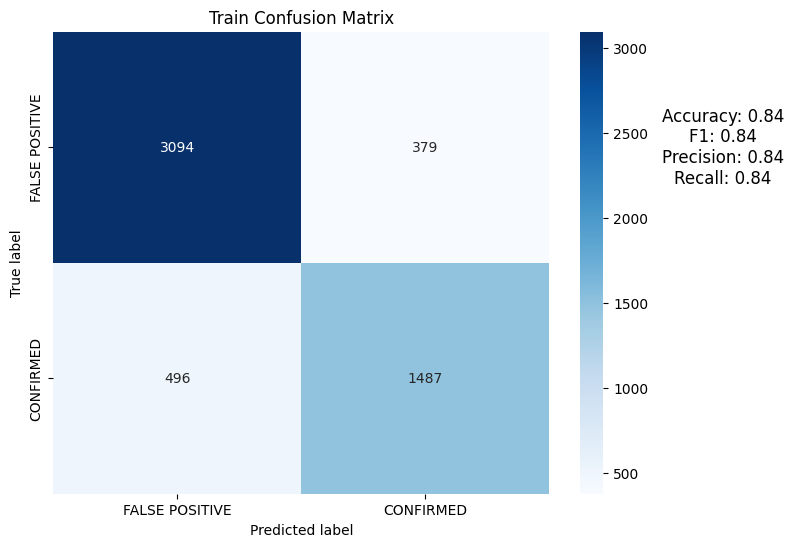

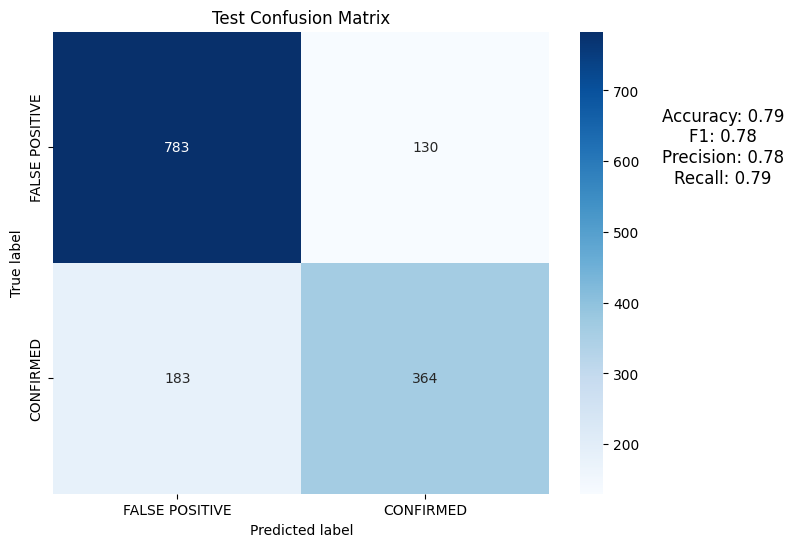

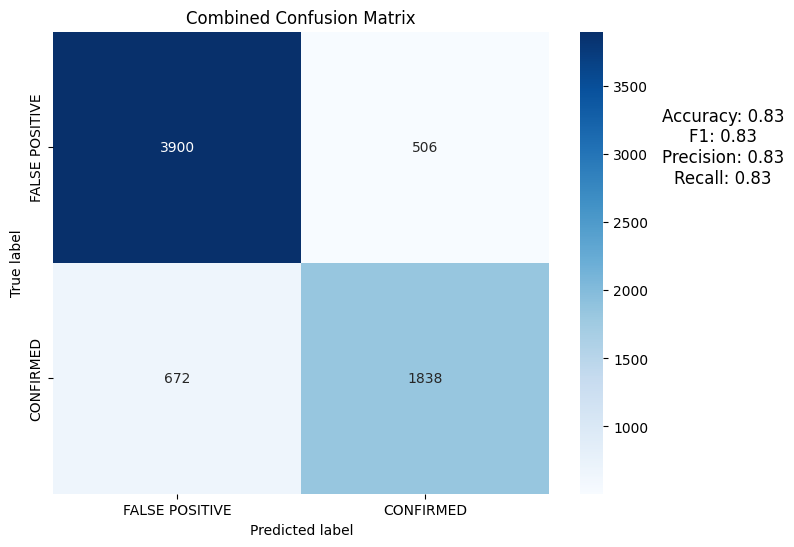

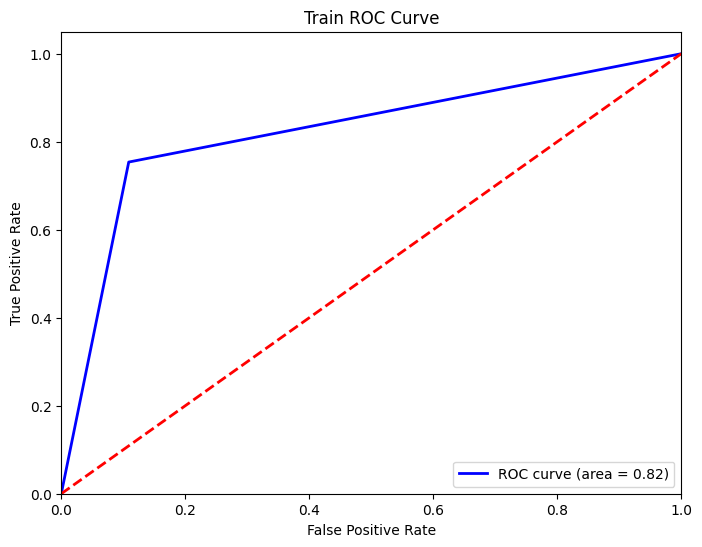

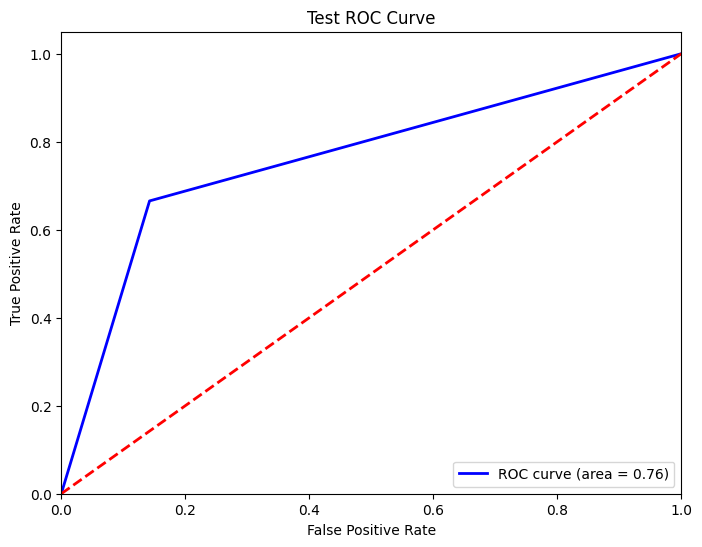

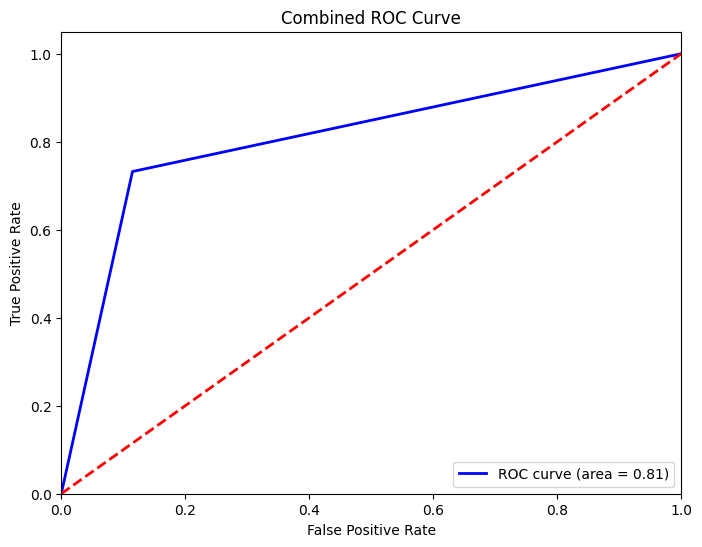

In [43]:

predicted, labels = predict(model, train_loader)
print("Predicciones y etiquetas de entrenamiento:", predicted, labels)
plot_confusion_matrix(labels, predicted, classes, title='Train Confusion Matrix')

predicted, labels = predict(model, test_loader)
plot_confusion_matrix(labels, predicted, classes, title='Test Confusion Matrix')

# combine the train and test datasets
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=False)
predicted, labels = predict(model, combined_loader)
plot_confusion_matrix(labels, predicted, classes, title='Combined Confusion Matrix')


# plot the ROC curve
def plot_roc_curve(y_true, y_pred, title='ROC Curve'):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()
    
predicted, labels = predict(model, train_loader)
plot_roc_curve(labels, predicted, title='Train ROC Curve')

predicted, labels = predict(model, test_loader)
plot_roc_curve(labels, predicted, title='Test ROC Curve')

predicted, labels = predict(model, combined_loader)
plot_roc_curve(labels, predicted, title='Combined ROC Curve')



## Probar el modelo con los datos de CANDIDATOS

In [45]:
global_odd = []
global_even = []
local_odd = []
local_even = []

for lc in tqdm(candidates, desc='Processing light curves'):
    global_odd.append(lc.pliegue_impar_global._light_curve.flux.value)
    global_even.append(lc.pliegue_par_global._light_curve.flux.value)
    local_odd.append(lc.pliegue_impar_local._light_curve.flux.value)
    local_even.append(lc.pliegue_par_local._light_curve.flux.value)

items = []
for i in tqdm(range(len(global_odd)), desc='Creating items'):
    item = {
        'global': (global_odd[i], global_even[i]),
        'local': (local_odd[i], local_even[i]),
        'label': -1 # No label for candidates
    }
    items.append(item)

candidates_global = torch.tensor([[item['global'][0], item['global'][1]] for item in items])
candidates_local = torch.tensor([[item['local'][0], item['local'][1]] for item in items])
candidates_labels = torch.tensor([item['label'] for item in items])
candidates_dataset = torch.utils.data.TensorDataset(candidates_global, candidates_local, candidates_labels)

print("Tamaño del conjunto de candidatos:", len(candidates_dataset))

candidates_loader = DataLoader(candidates_dataset, batch_size=batch_size, shuffle=False)

Creating items: 100%|██████████| 2046/2046 [00:00<00:00, 2047612.98it/s]


Tamaño del conjunto de candidatos: 2046


In [46]:
predicted_candidates, _ = predict(model, candidates_loader)


In [47]:
# contar los positivos y negativos
n_positive = sum(predicted_candidates)
n_negative = len(predicted_candidates) - n_positive
print("Exoplanetas confirmados:", n_positive)
print("Falso positivo:", n_negative)

Exoplanetas confirmados: 725.0
Falso positivo: 1065.0
